### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'Day042_training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

W0204 12:53:49.997858  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0204 12:53:50.013850  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0204 12:53:50.016807  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0204 12:53:50.032793  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0204 12:53:50.111558  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133:

In [8]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [9]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('Day044_best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('Day044_weights.h5')
# save the model
model.save('Day044_model.h5')

W0204 12:53:50.515471  8288 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 4s 3ms/step - loss: 0.0058 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00227, saving model to Day044_best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 473us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00227 to 0.00193, saving model to Day044_best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 481us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00193 to 0.00186, saving model to Day044_best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 481us/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00004: val_loss improved from 0.00186 to 0.00181, saving model to Day044_best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 1s 474us/step - loss: 0.0010 - val_loss: 0.0017

Epoch 00005: val_loss improved from 0.00181 to 0.

Epoch 43/150
1712/1712 [==============================] - 1s 470us/step - loss: 2.0191e-04 - val_loss: 7.5127e-04

Epoch 00043: val_loss did not improve from 0.00072
Epoch 44/150
1712/1712 [==============================] - 1s 472us/step - loss: 1.8545e-04 - val_loss: 7.2817e-04

Epoch 00044: val_loss did not improve from 0.00072
Epoch 45/150
1712/1712 [==============================] - 1s 475us/step - loss: 1.8602e-04 - val_loss: 7.1877e-04

Epoch 00045: val_loss did not improve from 0.00072
Epoch 46/150
1712/1712 [==============================] - 1s 477us/step - loss: 1.8543e-04 - val_loss: 7.7177e-04

Epoch 00046: val_loss did not improve from 0.00072
Epoch 47/150
1712/1712 [==============================] - 1s 471us/step - loss: 1.8533e-04 - val_loss: 7.1218e-04

Epoch 00047: val_loss improved from 0.00072 to 0.00071, saving model to Day044_best_weights.h5
Epoch 48/150
1712/1712 [==============================] - 1s 477us/step - loss: 1.8202e-04 - val_loss: 7.3350e-04

Epoch 00048

1712/1712 [==============================] - 1s 475us/step - loss: 8.8086e-05 - val_loss: 7.7082e-04

Epoch 00140: val_loss did not improve from 0.00070
Epoch 141/150
1712/1712 [==============================] - 1s 474us/step - loss: 8.9063e-05 - val_loss: 7.4362e-04

Epoch 00141: val_loss did not improve from 0.00070
Epoch 142/150
1712/1712 [==============================] - 1s 477us/step - loss: 8.6836e-05 - val_loss: 7.3679e-04

Epoch 00142: val_loss did not improve from 0.00070
Epoch 143/150
1712/1712 [==============================] - 1s 474us/step - loss: 8.3490e-05 - val_loss: 7.4244e-04

Epoch 00143: val_loss did not improve from 0.00070
Epoch 144/150
1712/1712 [==============================] - 1s 481us/step - loss: 8.2705e-05 - val_loss: 7.7876e-04

Epoch 00144: val_loss did not improve from 0.00070
Epoch 145/150
1712/1712 [==============================] - 1s 471us/step - loss: 8.5982e-05 - val_loss: 7.7378e-04

Epoch 00145: val_loss did not improve from 0.00070
Epoch 146/15

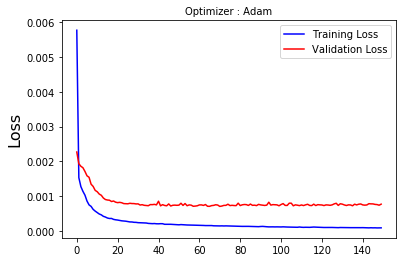

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [12]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'Day042_test.csv')

In [7]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

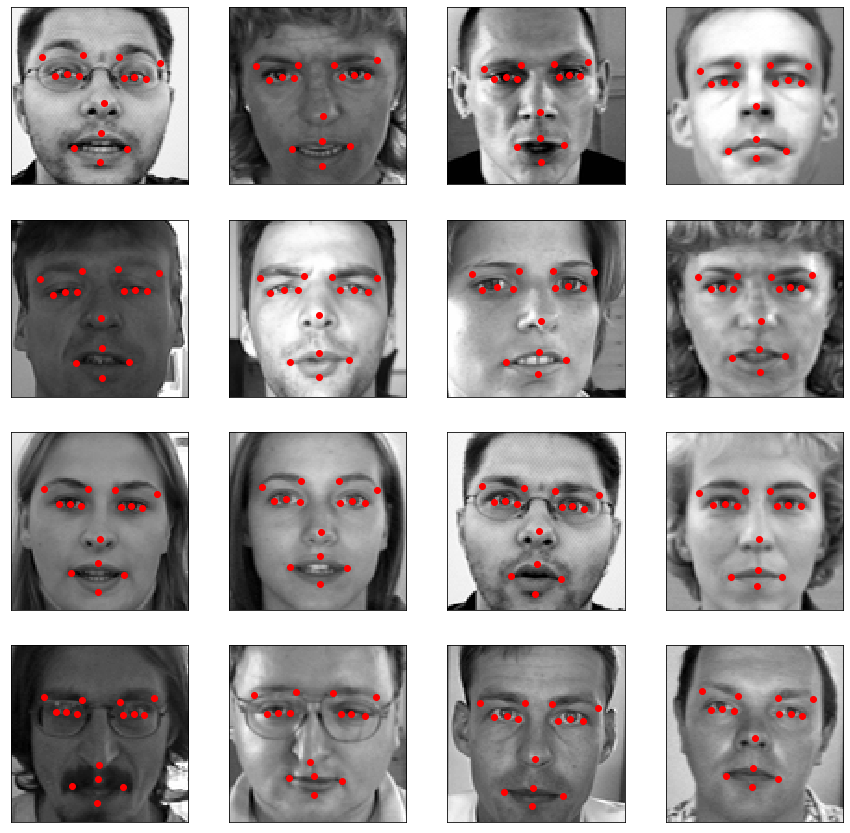

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

### Data Augumentation (with Horizontal Flip)

Orignial image


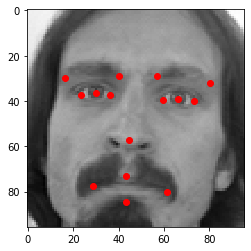

In [8]:
print("Orignial image")
plot_keypoints(imgs_train[0], np.squeeze(points_train[0]))

Flipped image


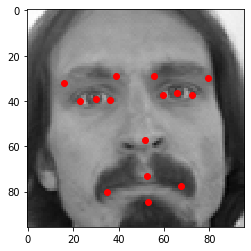

In [9]:
import imgaug.augmenters as iaa

# filp image
seq = iaa.Sequential([ iaa.Fliplr(1) ])
imgs_aug = seq(images = imgs_train)

# flip points
points_aug = points_train.copy()
for j in range(points_aug.shape[0]):
    for i in range(0, 30, 2):
        x = 96-((points_aug[j, i]+0.5) * 96)
        points_aug[j, i] = x/96 - 0.5

print("Flipped image")
plot_keypoints(imgs_aug[0], np.squeeze(points_aug[0]))

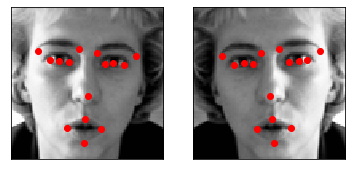

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[1], np.squeeze(points_train[1]))

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(imgs_aug[1], np.squeeze(points_aug[1]))

In [11]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

for i in range(imgs_train.shape[0]):
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 

for i in range(imgs_aug.shape[0]):
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(imgs_aug[i])
    aug_points_train.append(points_aug[i]) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape, aug_points_train.shape)

(4280, 96, 96) (4280, 30)


In [14]:
from keras.callbacks import ModelCheckpoint, History

hist = History()
model_with_aug = get_model()
model_with_aug.compile(loss='mean_squared_error', optimizer='adam')

# model checkpoint 
checkpoint_aug = ModelCheckpoint('Day044_best_weights_aug.h5', verbose=1, save_best_only=True)

# training the model
hist_model = model_with_aug.fit(aug_imgs_train.reshape(-1, 96, 96, 1),  aug_points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                       shuffle=True, epochs=150, verbose=1)

# save the model weights
model_with_aug.save_weights('Day044_weights_aug.h5')
# save the model
model_with_aug.save('Day044_model_aug.h5')

W0204 13:29:12.171099 19000 deprecation_wrapper.py:119] From c:\python36\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 5s 2ms/step - loss: 0.0187 - val_loss: 0.0245

Epoch 00001: val_loss improved from inf to 0.02450, saving model to Day044_best_weights_aug.h5
Epoch 2/150
3424/3424 [==============================] - 2s 472us/step - loss: 0.0118 - val_loss: 0.0374

Epoch 00002: val_loss did not improve from 0.02450
Epoch 3/150
3424/3424 [==============================] - 2s 473us/step - loss: 0.0060 - val_loss: 0.0396

Epoch 00003: val_loss did not improve from 0.02450
Epoch 4/150
3424/3424 [==============================] - 2s 471us/step - loss: 0.0039 - val_loss: 0.0459

Epoch 00004: val_loss did not improve from 0.02450
Epoch 5/150
3424/3424 [==============================] - 2s 476us/step - loss: 0.0029 - val_loss: 0.0528

Epoch 00005: val_loss did not improve from 0.02450
Epoch 6/150
3424/3424 [==============================] - 2s 476us/step - loss: 0.0024 - val_loss: 0.0518

Epoch 00006: val_los

3424/3424 [==============================] - 2s 481us/step - loss: 2.6478e-04 - val_loss: 0.0483

Epoch 00051: val_loss did not improve from 0.02450
Epoch 52/150
3424/3424 [==============================] - 2s 482us/step - loss: 2.6769e-04 - val_loss: 0.0505

Epoch 00052: val_loss did not improve from 0.02450
Epoch 53/150
3424/3424 [==============================] - 2s 481us/step - loss: 2.5888e-04 - val_loss: 0.0482

Epoch 00053: val_loss did not improve from 0.02450
Epoch 54/150
3424/3424 [==============================] - 2s 480us/step - loss: 2.5938e-04 - val_loss: 0.0491

Epoch 00054: val_loss did not improve from 0.02450
Epoch 55/150
3424/3424 [==============================] - 2s 480us/step - loss: 0.0016 - val_loss: 0.0417

Epoch 00055: val_loss did not improve from 0.02450
Epoch 56/150
3424/3424 [==============================] - 2s 478us/step - loss: 0.0059 - val_loss: 0.0495

Epoch 00056: val_loss did not improve from 0.02450
Epoch 57/150
3424/3424 [=========================

3424/3424 [==============================] - 2s 471us/step - loss: 2.5215e-04 - val_loss: 0.0478

Epoch 00102: val_loss did not improve from 0.02450
Epoch 103/150
3424/3424 [==============================] - 2s 476us/step - loss: 2.4452e-04 - val_loss: 0.0484

Epoch 00103: val_loss did not improve from 0.02450
Epoch 104/150
3424/3424 [==============================] - 2s 474us/step - loss: 2.4582e-04 - val_loss: 0.0481

Epoch 00104: val_loss did not improve from 0.02450
Epoch 105/150
3424/3424 [==============================] - 2s 478us/step - loss: 2.5018e-04 - val_loss: 0.0482-

Epoch 00105: val_loss did not improve from 0.02450
Epoch 106/150
3424/3424 [==============================] - 2s 475us/step - loss: 2.4669e-04 - val_loss: 0.0477

Epoch 00106: val_loss did not improve from 0.02450
Epoch 107/150
3424/3424 [==============================] - 2s 474us/step - loss: 2.4322e-04 - val_loss: 0.0480

Epoch 00107: val_loss did not improve from 0.02450
Epoch 108/150
3424/3424 [==========

NameError: name 'model' is not defined

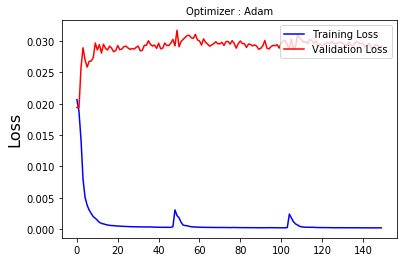

In [21]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')